In [14]:
import json
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

# Constants

In [25]:
actual_data = pd.read_csv('PROCESSED_ZORA_TEST.csv')

predictions_filepath = 'all_predictions_preprocessed_data.csv'

In [26]:
abstracts = actual_data['PROCESSED']
true_labels = actual_data['SDG']

In [27]:
base_models = ['muppet','scibert']
finetuned_variants = [
    'no_synth'
    ,'llama'
    ,'gpt-4'
    ,'ensemble'
    ,'mixtral'
]
models = [f"{b}_{v}" for b in base_models for v in finetuned_variants]

## Plots

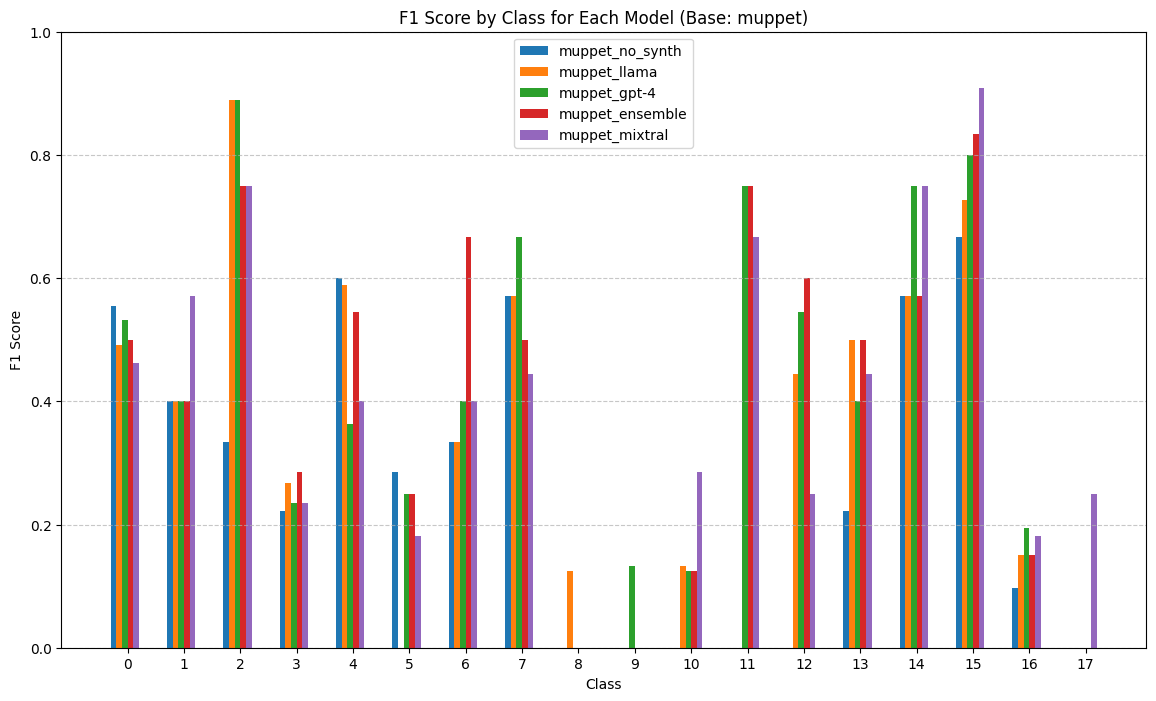

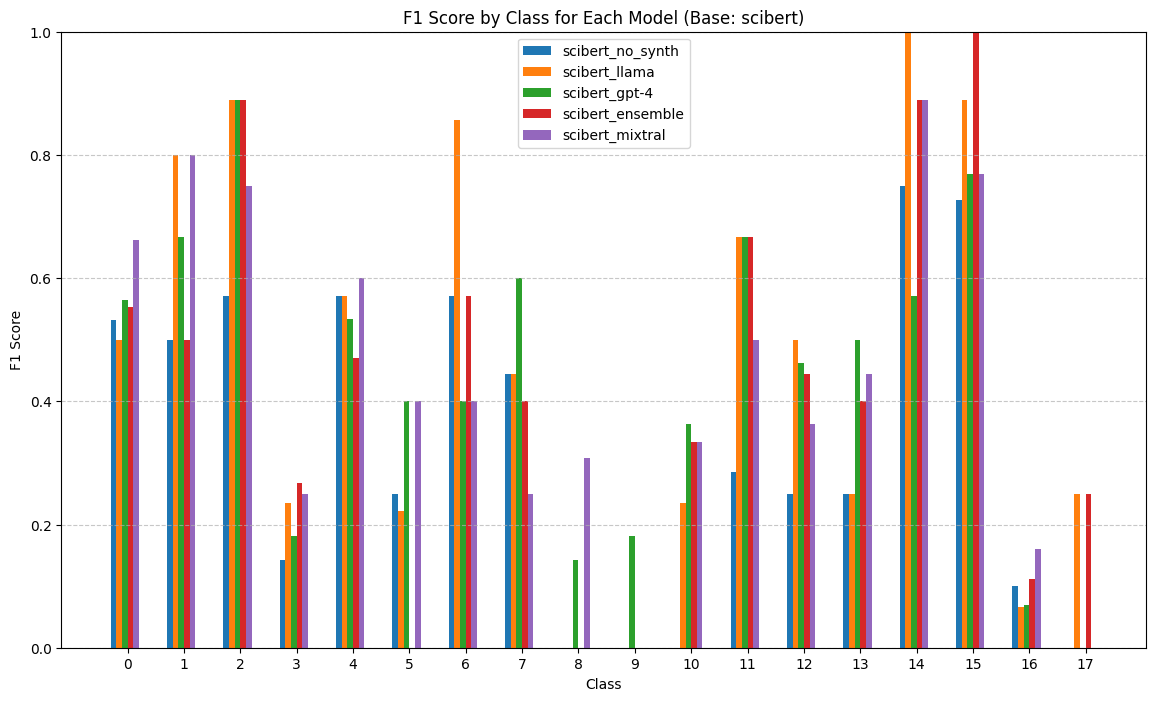

In [21]:
def plot_all(predictions_filepath, base_model):
    """
    Calculates and plots the F1 score of each model by class.

    Parameters:
    predictions_filepath (str): The path to the CSV file containing ze predictions.

    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(predictions_filepath)

    # Extract the true labels
    true_labels = df['truth'].values

    # Get the list of model names (columns) that start with the base_model prefix
    model_names = [col for col in df.columns if col.startswith(base_model)]

    # Initialize a dictionary to hold F1 scores for each model
    f1_scores_dict = {model: [] for model in model_names}
    classes = np.unique(true_labels)

    # Calculate F1 scores for each model
    for model in model_names:
        predicted_labels = df[model].values
        f1_scores = f1_score(true_labels, predicted_labels, average=None, labels=classes)
        f1_scores_dict[model] = f1_scores

    # Plot the F1 scores
    fig, ax = plt.subplots(figsize=(14, 8))
    bar_width = 0.1
    index = np.arange(len(classes))

    # Create bars for each model's F1 scores
    for i, model in enumerate(model_names):
        bar = ax.bar(index + i * bar_width, f1_scores_dict[model], bar_width, label=model)

    # Add labels and title
    ax.set_xlabel('Class')
    ax.set_ylabel('F1 Score')
    ax.set_title(f'F1 Score by Class for Each Model (Base: {base_model})')
    ax.set_xticks(index + bar_width * len(model_names) / 2)
    ax.set_xticklabels(classes)
    ax.set_ylim(0, 1)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.legend()

    # Display the plot
    plt.show()

for base_model in base_models:
    plot_all(predictions_filepath, base_model)

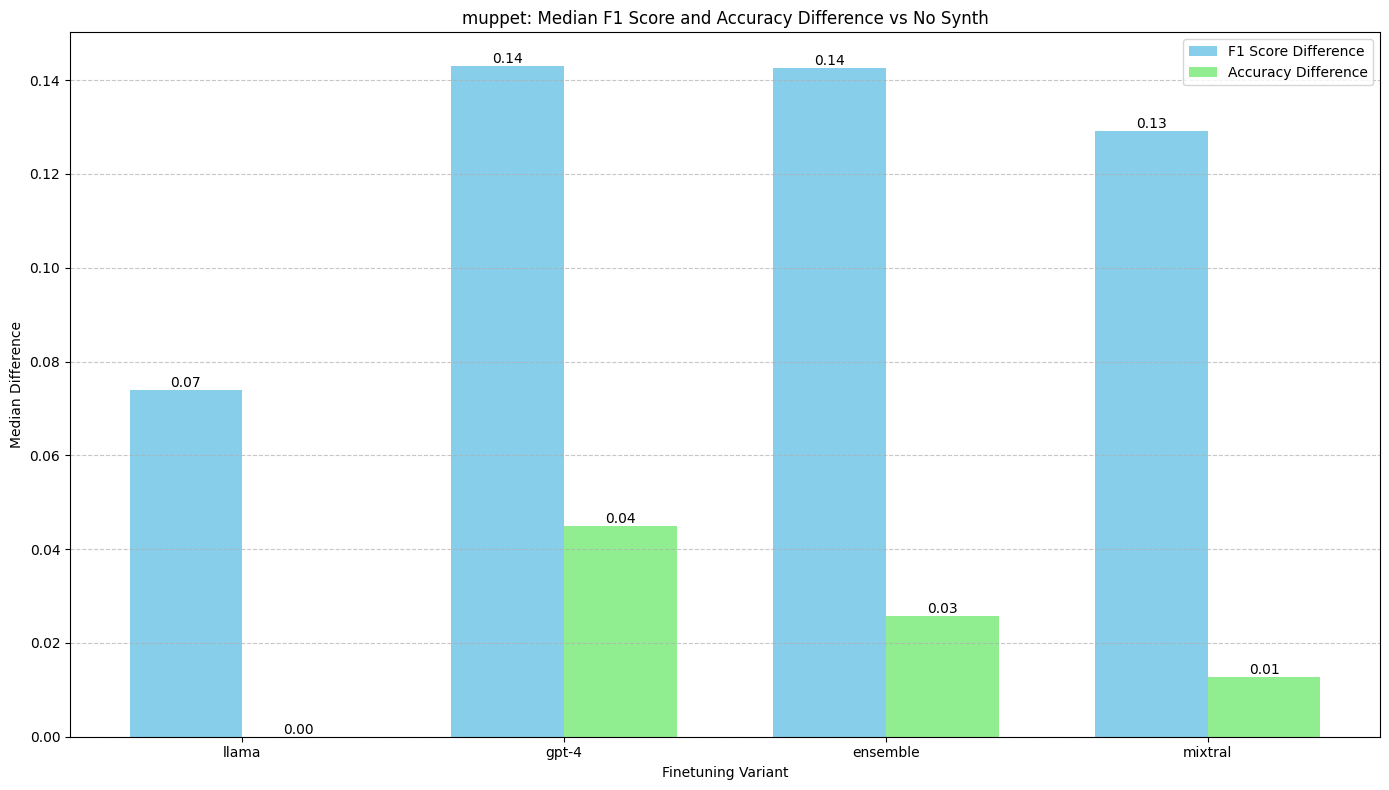

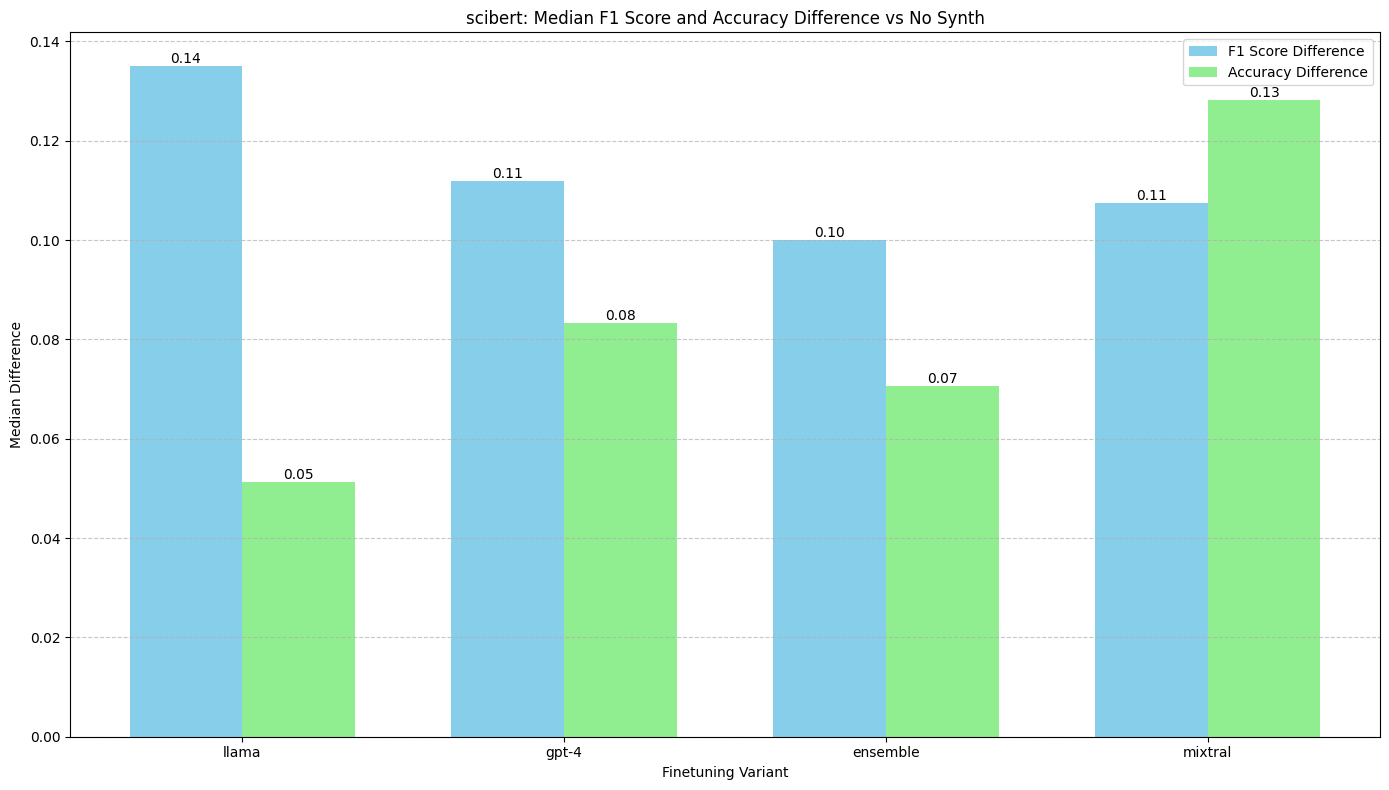

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score


def plot_finetuning_improvements(predictions_filepath, base_model, finetuned_variants):
    """
    Calculates and plots the median F1 and accuracy difference between the no_synth variant
    and the other finetuned variants for each base model.

    Parameters:
    predictions_filepath (str): The path to the CSV file containing the predictions.
    base_models (list): List of base models.
    finetuned_variants (list): List of finetuned variants.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(predictions_filepath)

    # Extract the true labels
    true_labels = df['truth'].values

    # Initialize dictionaries to hold differences
    f1_diff_dict = {variant: [] for variant in finetuned_variants if variant != 'no_synth'}
    acc_diff_dict = {variant: [] for variant in finetuned_variants if variant != 'no_synth'}

    # Get the no_synth model predictions
    no_synth_model = f"{base_model}_no_synth"
    no_synth_pred = df[no_synth_model].values

    # Calculate the F1 score and accuracy for the no_synth model
    no_synth_f1 = f1_score(true_labels, no_synth_pred, average='macro')
    no_synth_acc = accuracy_score(true_labels, no_synth_pred)

    for variant in finetuned_variants:
        if variant == 'no_synth':
            continue

        # Get the current model predictions
        model_name = f"{base_model}_{variant}"
        model_pred = df[model_name].values

        # Calculate the F1 score and accuracy for the current model
        model_f1 = f1_score(true_labels, model_pred, average='macro')
        model_acc = accuracy_score(true_labels, model_pred)

        # Calculate the differences
        f1_diff = model_f1 - no_synth_f1
        acc_diff = model_acc - no_synth_acc

        # Store the differences
        f1_diff_dict[variant].append(f1_diff)
        acc_diff_dict[variant].append(acc_diff)


    # Calculate median differences
    median_f1_diff = {variant: np.median(f1_diff_dict[variant]) for variant in f1_diff_dict}
    median_acc_diff = {variant: np.median(acc_diff_dict[variant]) for variant in acc_diff_dict}
    
    #  Plot the median differences
    fig, ax = plt.subplots(figsize=(14, 8))
    
    bar_width = 0.35
    variants = list(median_f1_diff.keys())
    index = np.arange(len(variants))
    
    # Plot median F1 score differences
    f1_bars = ax.bar(index, median_f1_diff.values(), bar_width, label='F1 Score Difference', color='skyblue')
    
    # Plot median accuracy differences
    acc_bars = ax.bar(index + bar_width, median_acc_diff.values(), bar_width, label='Accuracy Difference',
                      color='lightgreen')
    
    # Add labels and title
    ax.set_xlabel('Finetuning Variant')
    ax.set_ylabel('Median Difference')
    ax.set_title(f'{base_model}: Median F1 Score and Accuracy Difference vs No Synth')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(variants)
    ax.legend()
    
    # Add grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add text labels on top of the bars
    for bar in f1_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

    for bar in acc_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage
for base_model in base_models:
    plot_finetuning_improvements(predictions_filepath, base_model, finetuned_variants)




In [22]:
def generate_metrics_latex(predictions_filepath):
    """
    Calculates and displays the average F1 score and accuracy for each model combination in LaTeX format.

    Parameters:
    predictions_filepath (str): The path to the CSV file containing predictions.
    base_model (str): The base model name to filter columns.
    models (list): List of model combinations to consider.

    Returns:
    None
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(predictions_filepath)

    # Extract the true labels
    true_labels = df['truth'].values


    all_latex_code = "\\begin{table}[htbp]\n\\centering\n"

    for base_model in base_models:
        # Filter model names based on the given models list
        model_names = [col for col in df.columns if col in models and col.startswith(base_model)]

        # Initialize a list to hold the results
        results = []

        # Calculate average F1 scores and accuracy for each model
        for model in model_names:
            predicted_labels = df[model].values
            avg_f1 = np.mean(f1_score(true_labels, predicted_labels, average=None))
            accuracy = accuracy_score(true_labels, predicted_labels)
            results.append((model, avg_f1, accuracy))

        # Create a DataFrame for the results
        results_df = pd.DataFrame(results, columns=['Model', 'Average F1 Score', 'Accuracy'])

        # Identify the best metrics for bolding
        best_f1_score = results_df['Average F1 Score'].max()
        best_accuracy = results_df['Accuracy'].max()

        # Generate LaTeX code for the table
        latex_code = "\\begin{tabular}{c|c|c}\n\\hline\n"
        latex_code += "\\textbf{Model} & \\textbf{Average F1 Score} & \\textbf{Accuracy} \\\\\n\\hline\n"

        for index, row in results_df.iterrows():
            avg_f1 = f"\\textbf{{{row['Average F1 Score']:.2f}}}" if row['Average F1 Score'] == best_f1_score else f"{row['Average F1 Score']:.2f}"
            accuracy = f"\\textbf{{{row['Accuracy']:.2f}}}" if row['Accuracy'] == best_accuracy else f"{row['Accuracy']:.2f}"
            latex_code += f"{row['Model'].replace('_','-')} & {avg_f1} & {accuracy} \\\\\n"

        latex_code += "\\hline\n\\end{tabular}\n"
        all_latex_code += latex_code + "\\hspace{0.5cm}\n"

    all_latex_code += "\\caption{Average F1 Score and Accuracy for Models}\n\\label{tab:model_metrics}\n\\end{table}"

    # Print the LaTeX code
    print(all_latex_code)
    
generate_metrics_latex(predictions_filepath)

\begin{table}[htbp]
\centering
\begin{tabular}{c|c|c}
\hline
\textbf{Model} & \textbf{Average F1 Score} & \textbf{Accuracy} \\
\hline
muppet-no-synth & 0.27 & 0.38 \\
muppet-llama & 0.34 & 0.38 \\
muppet-gpt-4 & \textbf{0.41} & \textbf{0.42} \\
muppet-ensemble & 0.41 & 0.40 \\
muppet-mixtral & 0.40 & 0.39 \\
\hline
\end{tabular}
\hspace{0.5cm}
\begin{tabular}{c|c|c}
\hline
\textbf{Model} & \textbf{Average F1 Score} & \textbf{Accuracy} \\
\hline
scibert-no-synth & 0.33 & 0.38 \\
scibert-llama & \textbf{0.47} & 0.43 \\
scibert-gpt-4 & 0.44 & 0.46 \\
scibert-ensemble & 0.43 & 0.45 \\
scibert-mixtral & 0.44 & \textbf{0.51} \\
\hline
\end{tabular}
\hspace{0.5cm}
\caption{Average F1 Score and Accuracy for Models}
\label{tab:model_metrics}
\end{table}
